# Flexfringe Hyperparameter Study

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split
import itertools
import os
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import multiprocessing
import copy

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.automaton import Automaton
from wombats.learning import FlexfringeInterface
from wombats.utils import get_experiment_paths

# setting all paths
EXPERIMENT_NAME = 'flexfringe_hyperparameter_study'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

/Users/nicholasrenninger/anaconda3/envs/dfaInvestigations/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Loading in the Specification

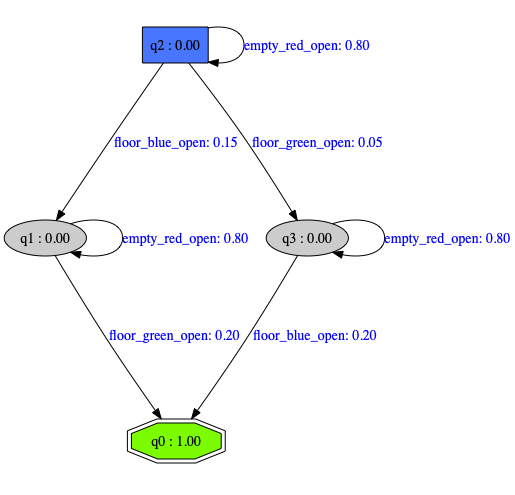

In [3]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)
pdfa_specification.draw('_'.join([EXPERIMENT_NAME, 'PDFA']))

## Learning the Specification

We will take this specification and learn it using `Flexfringe`

### Creating Training / Test Data

Here, we choose a 90/10 training/test split in our data using N samples fron the target specification.

In [8]:
num_samples = 100
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    traces_train,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)
test_data_file = pdfa_specification.write_traces_to_file(
    traces_test,
    file=LEARNING_TEST_DATA_REL_FILEPATH)

### Learning with `Flexfringe`

We are going to use the wombats wrapper to learn the specification.

In [5]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)
flexfringe.infer_model(get_help=True)
flexfringe.num_training_examples = len(traces_train)

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

Here, we are going to do a grid search over all possible choices of hyperparameters to try to identify a good way to programatically set the hyperparameters:

In [6]:
NUM_P_VALUES = 100
P_VALUES = [str(i / NUM_P_VALUES) for i in range(NUM_P_VALUES)]

L_VAL = [0, 5]
L_VALUES = [str(val) for val in L_VAL]

MIN_STATE_COUNT_VAL = range(0, 10)
MIN_STATE_COUNT_VALUES = [str(val) for val in MIN_STATE_COUNT_VAL]

MIN_SYMBOL_COUNT_VAL = range(0, 10)
MIN_SYMBOL_COUNT_VALUES = [str(val) for val in MIN_SYMBOL_COUNT_VAL]

param_possibilities = {'m': ['2'],
                       'n': ['5'],
                       'x': ['0'],
                       'w': ['1'],
                       'a': ['1'],
                       'b': ['1'],
                       'f': ['1'],
                       'I': ['1'],
                       'J': ['0'],
                       'K': ['0'],
                       't': ['1'],
                       'l': L_VALUES,
                       'q': MIN_STATE_COUNT_VALUES,
                       'y': MIN_SYMBOL_COUNT_VALUES,
                       'p': P_VALUES}

param_names = list(param_possibilities.keys())
all_param_combos = list(itertools.product(*param_possibilities.values()))

def eval_param(ff, param, active_automata, param_names):
    params_to_try = {key: value for key, value in zip(param_names, param)}
    
    flexyfringy = copy.deepcopy(ff)
    param_str = '_'.join(f'{key}{val}'
                         for key, val in params_to_try.items())
    unique_fname = param_str.replace('.', '_')
    new_out_fname = unique_fname + flexyfringy._output_filename
    flexyfringy._output_filename = new_out_fname

    flexyfringy.infer_model(training_file=train_data_file,
                            h='kldistance', d='kl_data', go_fast=True,
                            o=os.path.join(LEARNER_DATA_DIR, new_out_fname),
                            **params_to_try)

    learned_fdfa = active_automata.get(automaton_type='FDFA',
                                       graph_data=flexyfringy,
                                       graph_data_format='learning_interface')
    learned_pdfa = active_automata.get(automaton_type='PDFA',
                                       graph_data=learned_fdfa,
                                       graph_data_format='fdfa_object',
                                       smooth_transitions=False)
    learning_success = True

    PP = learned_pdfa.perplexity(traces_test, trace_probs_test)

    if learned_pdfa._num_states in (3, 4, 5) and PP < 2:
        curr_automaton = tuple(learned_pdfa.edges)

        new_fname = os.path.join('hp_opt/', unique_fname)
        fpath = os.path.join(learned_pdfa._automata_display_dir, new_fname)
        learned_pdfa.draw(new_fname, should_display=False)

In [7]:
for param in tqdm(all_param_combos):
    eval_param(flexfringe, param, active_automata, param_names)

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_blue_open) is not found in the curr_state's (q62) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: User

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_blue_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q226) transition distribution
  warnings.warn(str(e))


KeyboardInterrupt: 

While much faster, this does not appear to full work. Probably some file race conditions. Too lazy to set up a properly queued implementation.

In [ ]:
NUM_CORES = multiprocessing.cpu_count()

runner = Parallel(n_jobs=NUM_CORES, verbose=1)
job = delayed(eval_param)
runner(job(flexfringe, param, active_automata, param_names)
       for param in all_param_combos)